Notebook to make some final plots of yield and spectra for the R68 paper

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
#Set up notebook and load some R68 constants (V, eps, etc.)
exec(open("nb_setup.py").read())#Is there a better way to do this?
from constants import *
import R68_spec_tools as spec
import R68_yield as Yield
from tqdm.notebook import tqdm
from matplotlib.pyplot import *

../mplstyles
3.1.1
/data/chocula/mast/cdms/analysis/run068/R68_paper2019/mplstyles
dict_keys(['xx', 'yy', 'ex', 'ey'])


In [3]:
#Turns out we need the helper functions to still be defined since the stored samplers rely on them.
#Don't think it matters if they're exactly the same as what was used, since we don't use them here.
def Fit_helper(theta):
    return calc_log_prob(model='Sor', theta=theta, theta_bounds=((0,1),(0,3e-2),(0,10),(0,5)),
                         spec_bounds=(5,101), likelihood='Pois')

In [79]:
import R68_plot_tools as pt
import matplotlib.patches as mpatches
import pickle as pkl

#model_label='Sorensen'
#fnames=['data/mcmc_Sor_128walk_50kstep_SNorm_v3.pkl',
#        'data/mcmc_Sor_128walk_50kstep_SNorm_v4.pkl']

model_label='Lindhard'
fnames=['data/mcmc_Lind_128walk_50kstep_SNorm_v1.pkl',
        'data/mcmc_Lind_128walk_50kstep_SNorm_v2.pkl']


plot_fill_colors=['g','g']
plot_alphas=[1,0.5]
plot_zorders=[2,1,0]
plot_labels=['This work: Stat','Stat+Syst']#,'+BurstSyst']

mcmc_datas=[]
for fname in fnames:
    with open(fname,'rb') as file:
        mcmc_datas.append(pkl.load(file))
RQss=[]
for datai in mcmc_datas:
    RQss.append(datai['RQs'])

In [80]:
from scipy.optimize import fsolve
from scipy.special import erf

def ERtoNR(ER,Y,V,eps):
    func = lambda NR : NR-ER*(1+V/eps)/(1+Y.calc(NR)*V/eps)
    NR_guess = ER
    return fsolve(func, NR_guess)

def NRtoER(NR,Y,V,eps):
    return NR*(1+Y.calc(NR)*V/eps)/(1+V/eps)

Make side-by-side yield and spectra plots.
Follow the same format we used at the end of R68_integral_yield_analysis.ipynb

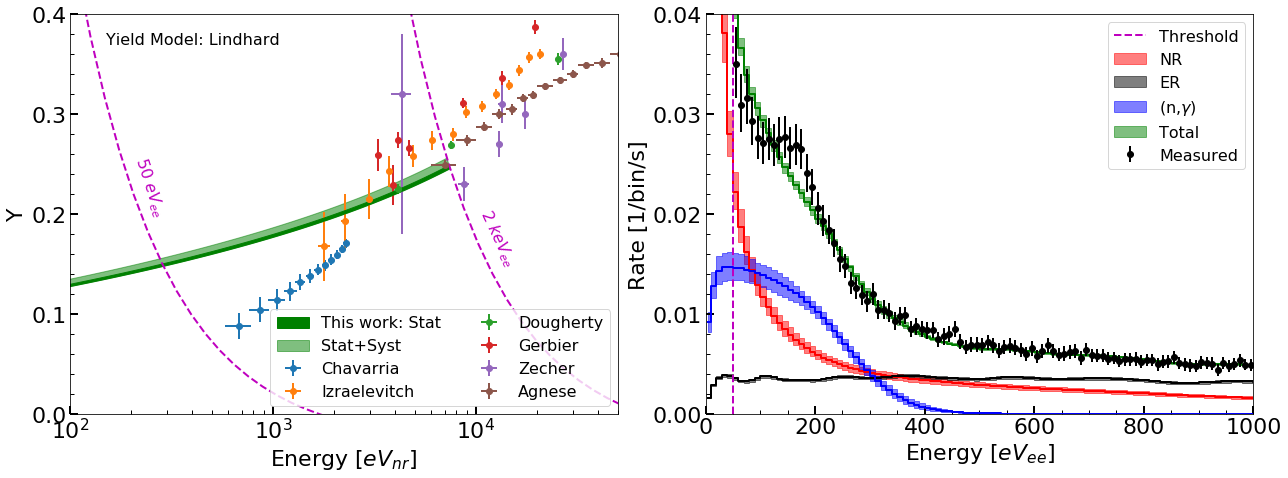

In [82]:
fig_w=9
fig,axs=subplots(1,2,figsize=(2*fig_w, fig_w*(.75)))


#Add other measurements from lit
import R68_plot_tools as pt
#pt.plotOldYs(axs[0],fmt='o',markersize=6)
pt.plotOldYs(axs[0],datasets=['chav','izr','dough','gerb','zech','agnese'],
             labels=['Chavarria','Izraelevitch','Dougherty','Gerbier','Zecher','Agnese'],
             fmt='o',markersize=6)

axs[0].text(1.5e2,0.37,'Yield Model: '+model_label,size=16)

for i,RQi in enumerate(RQss):
    #axs[0].fill_between(RQi['Er_Ycalc'],RQi['Ydist'][1],RQi['Ydist'][2],color=plot_fill_colors[i],zorder=plot_zorders[i], alpha=0.5, label=plot_labels[i])
    Er_Ycalc_plot=np.concatenate((RQi['Er_Ycalc'][0][:1],RQi['Er_Ycalc'][1],RQi['Er_Ycalc'][0][-1:],RQi['Er_Ycalc'][2][::-1]))
    Ydist_plot=np.concatenate((RQi['Ydist'][0][:1],RQi['Ydist'][1],RQi['Ydist'][0][-1:],RQi['Ydist'][2][::-1]))

    axs[0].fill(Er_Ycalc_plot,Ydist_plot,color=plot_fill_colors[i],zorder=plot_zorders[i], alpha=plot_alphas[i], label=plot_labels[i])



Ebins=mcmc_datas[1]['Ebins']
Ebin_ctr=(Ebins[:-1]+Ebins[1:])/2

axs[1].errorbar(Ebin_ctr[Ebin_ctr>50],RQss[1]['N_meas'][Ebin_ctr>50],(RQss[1]['dN_meas'].T[Ebin_ctr>50]).T,
                ecolor='k', marker='o',markersize=6,color='k', linestyle='none',label='Measured',zorder=5)

axs[0].set_prop_cycle(None)#Reset color cycle
axs[1].set_prop_cycle(None)

axs[1].step(Ebin_ctr,RQss[1]['N_nr_plot'][0],color='r',where='mid')
axs[1].step(Ebin_ctr,RQss[1]['N_er_plot'][0],color='k',where='mid')
axs[1].step(Ebin_ctr,RQss[1]['N_ng_plot'][0],color='b',where='mid')
axs[1].step(Ebin_ctr,RQss[1]['N_tot_plot'][0],color='g',where='mid')

axs[1].fill_between(Ebin_ctr,RQss[1]['N_nr_plot'][1],RQss[1]['N_nr_plot'][2],color='r',alpha=0.5,step='mid',label='NR')
axs[1].fill_between(Ebin_ctr,RQss[1]['N_er_plot'][1],RQss[1]['N_er_plot'][2],color='k',alpha=0.5,step='mid',label='ER')
axs[1].fill_between(Ebin_ctr,RQss[1]['N_ng_plot'][1],RQss[1]['N_ng_plot'][2],color='b',alpha=0.5,step='mid',label=r'(n,$\gamma)$')
axs[1].fill_between(Ebin_ctr,RQss[1]['N_tot_plot'][1],RQss[1]['N_tot_plot'][2],color='g',alpha=0.5,step='mid',label='Total')

#Analysis Range
axs[1].axvline(50,linestyle='--',color='m',label='Threshold')

Yiso = lambda Enr,Eee: Eee/Enr*(1+eps/V)-eps/V
axs[0].plot(np.logspace(-2,5,100),Yiso(np.logspace(-2,5,100),50),'--m')
axs[0].plot(np.logspace(-2,5,100),Yiso(np.logspace(-2,5,100),2e3),'--m')

axs[0].text(2e2,0.2,r'50 $eV_{ee}$',size=16,color='m',rotation=-72)
axs[0].text(1e4,0.15,r'2 $keV_{ee}$',size=16,color='m',rotation=-65)

#Axes
#axs[0].set_xlim(0,5e2)
axs[0].set_xlim(1e2,5e4);
axs[0].set_xscale('log')
axs[0].set_ylim(0,0.4)
axs[0].yaxis.set_major_locator(plt.MultipleLocator(0.1))
axs[0].set_xlabel(r'Energy [$eV_{nr}$]')
axs[0].set_ylabel('Y')
axs[0].legend(loc='lower right',ncol=2,prop={'size': 16})

axs[1].set_ylim(0,0.04)
axs[1].yaxis.set_major_locator(plt.MultipleLocator(0.01))
axs[1].set_xlim(0,1e3)
#axs[1].set_xscale('log')
#axs[1].set_xlim(0,250)
axs[1].set_xlabel(r'Energy [$eV_{ee}$]')
axs[1].set_ylabel('Rate [1/bin/s]')

axs[1].legend(loc='upper right', prop={'size': 16})

tight_layout()

#savefig('figures/mcmc_Y_and_spec_sor.png')
#savefig('figures/mcmc_Y_and_spec_lind.png')

In [50]:
importlib.reload(pt)

<module 'R68_plot_tools' from '../python/R68_plot_tools.py'>